In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import h5py

## Loading

In [6]:
dataset_folder = '../data/GPVS-Faults'

filenames = os.listdir(dataset_folder)

class_names = [filename[:3] for filename in filenames]

le = LabelEncoder()
le.fit(class_names)
print(le.classes_)

['CSV' 'F0L' 'F0M' 'F1L' 'F1M' 'F2L' 'F2M' 'F3L' 'F3M' 'F4L' 'F4M' 'F5L'
 'F5M' 'F6L' 'F6M' 'F7L' 'F7M' 'Rea']


In [7]:
import h5py

path = '../data/GPVS-Faults/F0L.mat'

with h5py.File(path, 'r') as f:
    def print_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            shape = obj.shape
            dtype = obj.dtype
            if len(shape) > 0:
                print(f"🔹 {name:40s} shape={shape} dtype={dtype}")
    f.visititems(print_dataset)


🔹 #refs#/A                                 shape=(2, 1) dtype=uint16
🔹 #refs#/B                                 shape=(2, 1) dtype=uint16
🔹 #refs#/C                                 shape=(2, 1) dtype=uint16
🔹 #refs#/D                                 shape=(2, 1) dtype=uint16
🔹 #refs#/E                                 shape=(2, 1) dtype=uint16
🔹 #refs#/F                                 shape=(2, 1) dtype=uint16
🔹 #refs#/G                                 shape=(4, 1) dtype=uint16
🔹 #refs#/H                                 shape=(2, 1) dtype=uint16
🔹 #refs#/I                                 shape=(4, 1) dtype=uint16
🔹 #refs#/J                                 shape=(2, 1) dtype=uint16
🔹 #refs#/K/CustomProps                     shape=(2,) dtype=uint64
🔹 #refs#/K/Description                     shape=(2,) dtype=uint64
🔹 #refs#/K/DimensionNames                  shape=(2, 1) dtype=object
🔹 #refs#/K/DimensionNamesOriginal          shape=(2,) dtype=uint64
🔹 #refs#/K/UserData                     

In [15]:

path = '../data/GPVS-Faults/F0L.mat'

with h5py.File(path, 'r') as f:
    # from D to Q 14 columns
    keys = [k for k in f['#refs#'].keys() if k >= 'd' and k <= 'q']
    data_arrays = [np.array(f['#refs#/'+ k]).ravel() for k in keys]
    data = np.vstack(data_arrays).T 
    print("shape:", data.shape)

    # the name of each column
    
    names = []
    for ref in f['#refs#/v']:## v variable name
        obj = f[ref[0]]
        s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
        names.append(s)
    

F0L = pd.DataFrame(data, columns=names)
print(F0L.head())


shape: (143715, 14)
       Time       Ipv         Vpv         Vdc        ia        ib        ic  \
0  0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112 -0.354985   
1  0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254 -0.388555   
2  0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826 -0.334844   
3  0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254 -0.361699   
4  0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540 -0.321416   

          va          vb          vc  Iabc    If  Vabc    Vf  
0  41.744537 -149.872894  109.064585   1.0  50.0   1.0  50.0  
1  46.831512 -150.716705  105.829976   1.0  50.0   1.0  50.0  
2  51.074677 -152.018585  102.543132   1.0  50.0   1.0  50.0  
3  55.848236 -152.585144   98.143260   1.0  50.0   1.0  50.0  
4  60.055237 -152.609253   94.261729   1.0  50.0   1.0  50.0  


In [18]:
path = '../data/GPVS-Faults/F0L.mat'

with h5py.File(path, 'r') as f:
    # from D to Q 14 columns
    keys = [k for k in f['#refs#'].keys() if k >= 'd' and k <= 'q']
    data_arrays = [np.array(f['#refs#/'+ k]).ravel() for k in keys]
    data = np.vstack(data_arrays).T 
    print("shape:", data.shape)

    # the name of each column
    
    names = []
    for ref in f['#refs#/v']:## v variable name
        obj = f[ref[0]]
        s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
        names.append(s)
    

F0L = pd.DataFrame(data, columns=names)
print(F0L.head())
print(F0L.shape)

shape: (143715, 14)
       Time       Ipv         Vpv         Vdc        ia        ib        ic  \
0  0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112 -0.354985   
1  0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254 -0.388555   
2  0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826 -0.334844   
3  0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254 -0.361699   
4  0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540 -0.321416   

          va          vb          vc  Iabc    If  Vabc    Vf  
0  41.744537 -149.872894  109.064585   1.0  50.0   1.0  50.0  
1  46.831512 -150.716705  105.829976   1.0  50.0   1.0  50.0  
2  51.074677 -152.018585  102.543132   1.0  50.0   1.0  50.0  
3  55.848236 -152.585144   98.143260   1.0  50.0   1.0  50.0  
4  60.055237 -152.609253   94.261729   1.0  50.0   1.0  50.0  
(143715, 14)


In [10]:
def read_mat_file(path, label):
    with h5py.File(path, 'r') as f:
        # from D to Q 14 columns
        keys = [k for k in f['#refs#'].keys() if 'd' <= k <= 'q']
        data_arrays = [np.array(f['#refs#/' + k]).ravel() for k in keys]
        data = np.vstack(data_arrays).T

        # the name of each column
        names = []
        for ref in f['#refs#/v']:
            obj = f[ref[0]]
            s = obj[:].tobytes().decode('utf-16', errors='ignore').strip('\x00')
            names.append(s)

    df = pd.DataFrame(data, columns=names)
    df["label"] = label
    print(f"{label} loaded, shape = {df.shape}")
    return df

In [27]:
F0L = read_mat_file("../data/GPVS-Faults/F0L.mat", "F0L")
F1L = read_mat_file("../data/GPVS-Faults/F1L.mat", "F1L")
F2L = read_mat_file("../data/GPVS-Faults/F2L.mat", "F2L")
F3L = read_mat_file("../data/GPVS-Faults/F3L.mat", "F3L")
F4L = read_mat_file("../data/GPVS-Faults/F4L.mat", "F4L")
F5L = read_mat_file("../data/GPVS-Faults/F5L.mat", "F5L")
F6L = read_mat_file("../data/GPVS-Faults/F6L.mat", "F6L")
F7L = read_mat_file("../data/GPVS-Faults/F7L.mat", "F7L")
F0M = read_mat_file("../data/GPVS-Faults/F0M.mat", "F0M")
F1M = read_mat_file("../data/GPVS-Faults/F1M.mat", "F1M")
F2M = read_mat_file("../data/GPVS-Faults/F2M.mat", "F2M")
F3M = read_mat_file("../data/GPVS-Faults/F3M.mat", "F3M")
F4M = read_mat_file("../data/GPVS-Faults/F4M.mat", "F4M")
F5M = read_mat_file("../data/GPVS-Faults/F5M.mat", "F5M")
F6M = read_mat_file("../data/GPVS-Faults/F6M.mat", "F6M")
F7M = read_mat_file("../data/GPVS-Faults/F7M.mat", "F7M")
print(F0L.head())

F0L loaded, shape = (143715, 15)
F1L loaded, shape = (129013, 15)
F2L loaded, shape = (142128, 15)
F3L loaded, shape = (103497, 15)
F4L loaded, shape = (144014, 15)
F5L loaded, shape = (143015, 15)
F6L loaded, shape = (144015, 15)
F7L loaded, shape = (144015, 15)
F0M loaded, shape = (141014, 15)
F1M loaded, shape = (139014, 15)
F2M loaded, shape = (144015, 15)
F3M loaded, shape = (69967, 15)
F4M loaded, shape = (144014, 15)
F5M loaded, shape = (144014, 15)
F6M loaded, shape = (144015, 15)
F7M loaded, shape = (144015, 15)
       Time       Ipv         Vpv         Vdc        ia        ib        ic  \
0  0.000028  1.572327  101.348877  144.140625 -0.135133  0.490112 -0.354985   
1  0.000128  1.503265  101.458740  143.554688 -0.108277  0.510254 -0.388555   
2  0.000228  1.492859  101.574707  143.554688 -0.168702  0.496826 -0.334844   
3  0.000328  1.558136  101.312256  143.261719 -0.135133  0.510254 -0.361699   
4  0.000428  1.631927  101.141357  143.847656 -0.202271  0.503540 -0.321416   

In [28]:
# Combine all files
solar_power = pd.concat([F0L, F1L, F2L, F3L, F4L, F5L, F6L, F7L,F0M, F1M, F2M, F3M, F4M, F5M, F6M, F7M], ignore_index=True)
# Combine all L files
solar_Lim_power = pd.concat([F0L, F1L, F2L, F3L, F4L, F5L, F6L, F7L], ignore_index=True)
# Combine all M files
solar_Max_power = pd.concat([F0M, F1M, F2M, F3M, F4M, F5M, F6M, F7M], ignore_index=True)

c:\Users\lenovo\anaconda3\envs\env_torch\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


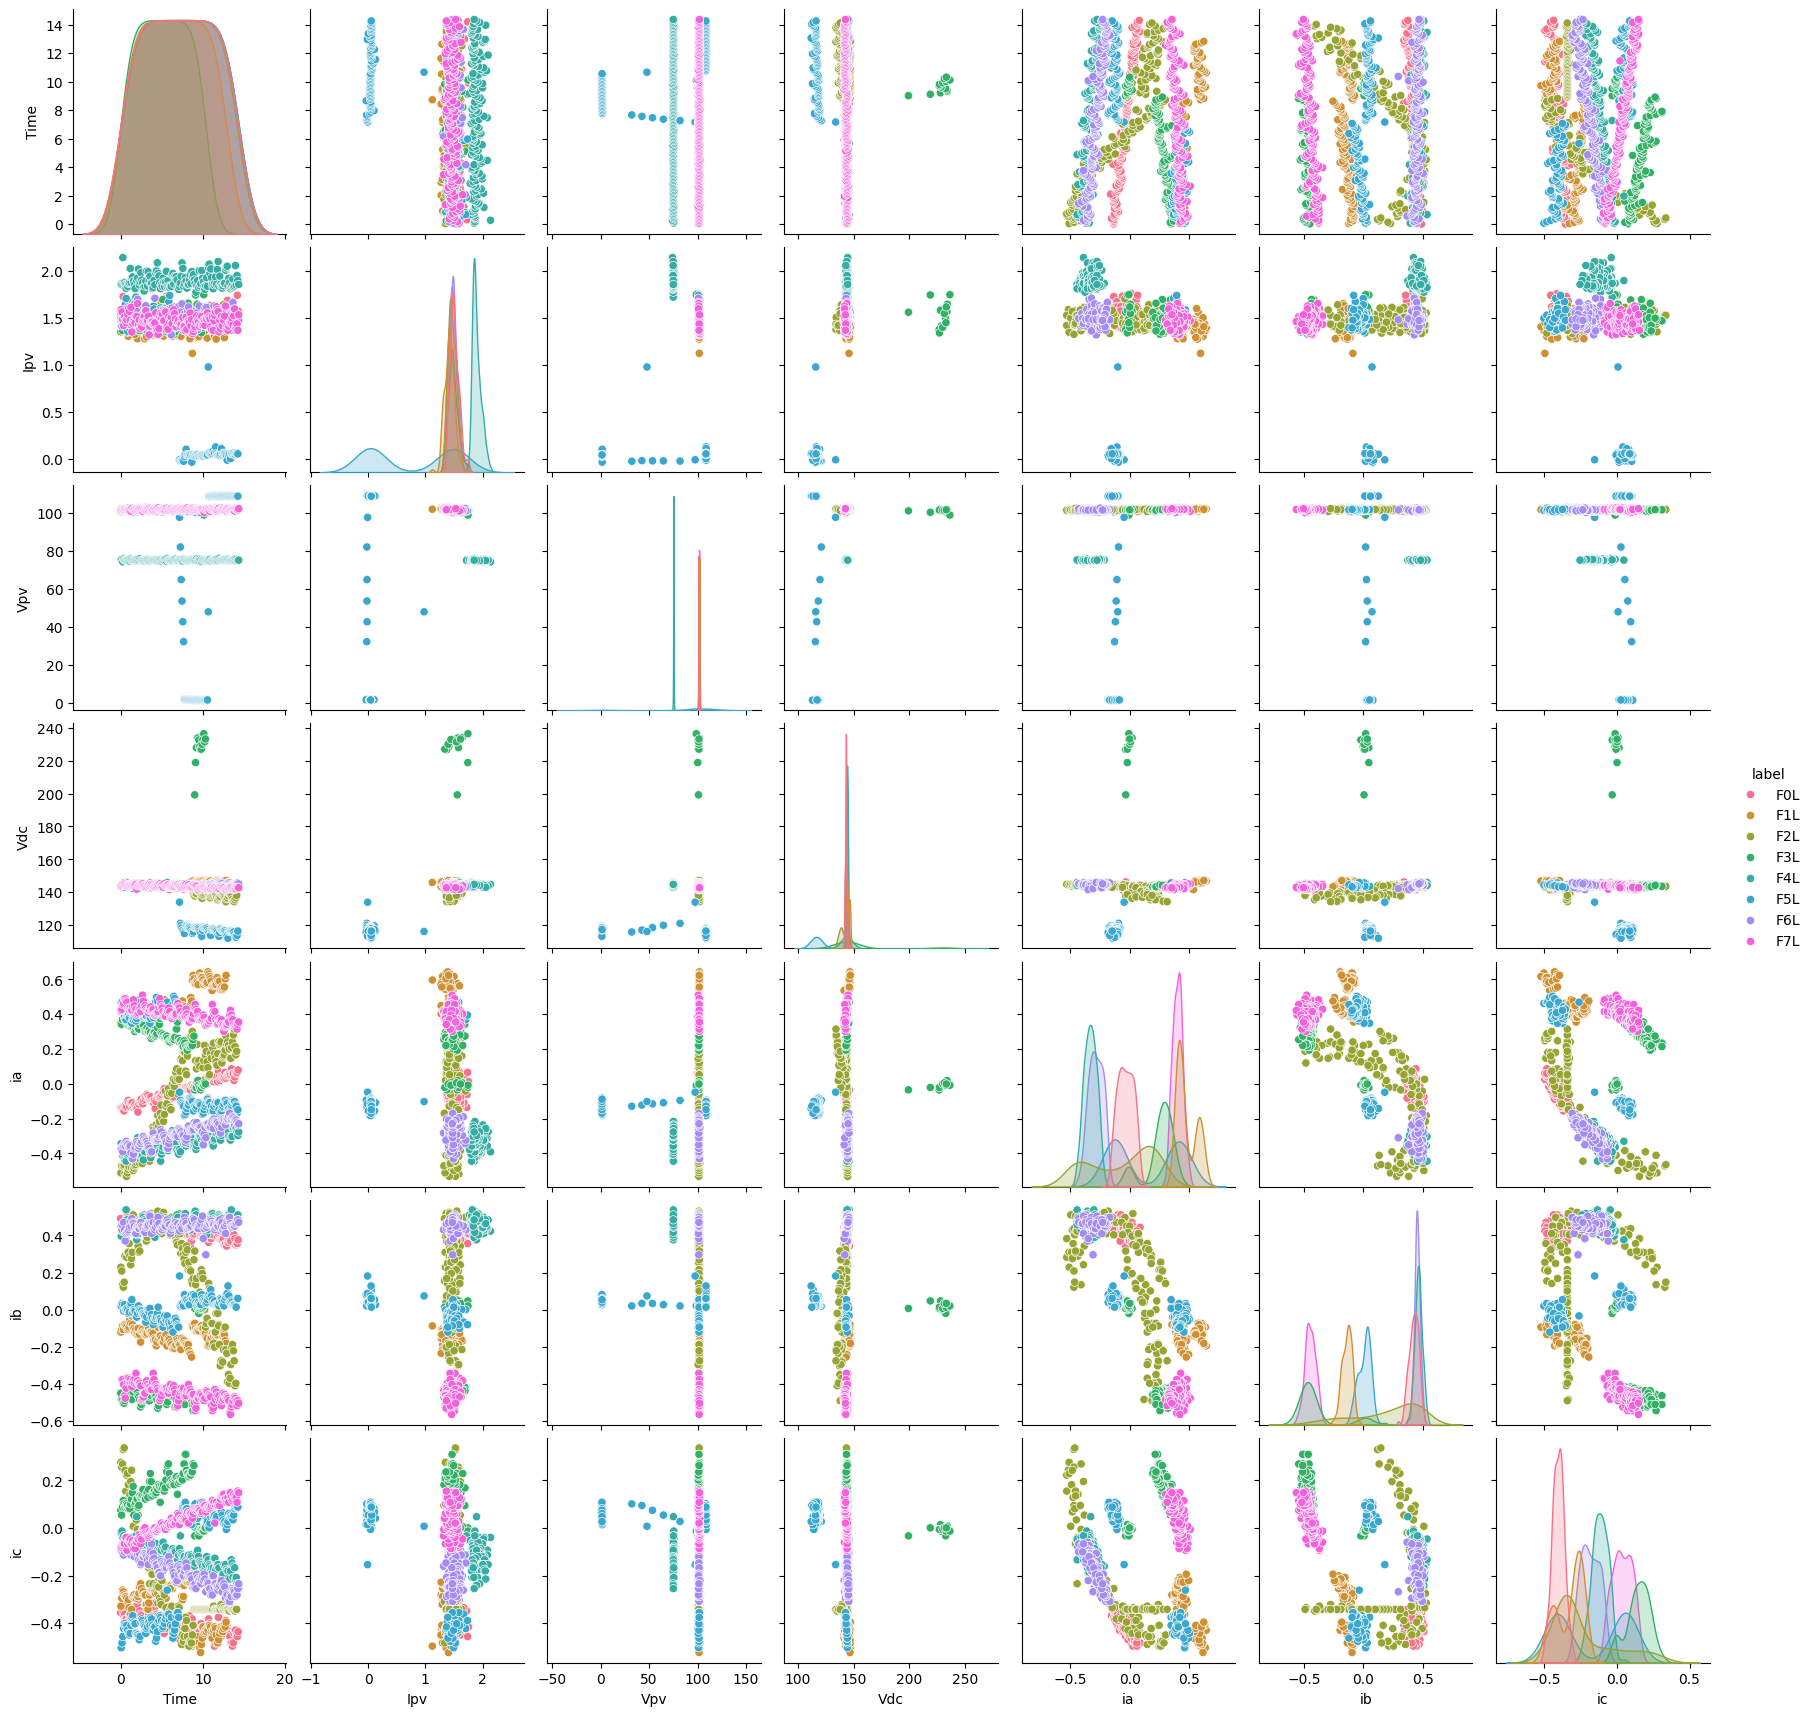

In [29]:
solar_Lim_power1= solar_Lim_power.iloc[::1000,:]
sns.pairplot(solar_Lim_power1[['Time','Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'label']], hue='label', palette='husl')
plt.show()

c:\Users\lenovo\anaconda3\envs\env_torch\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


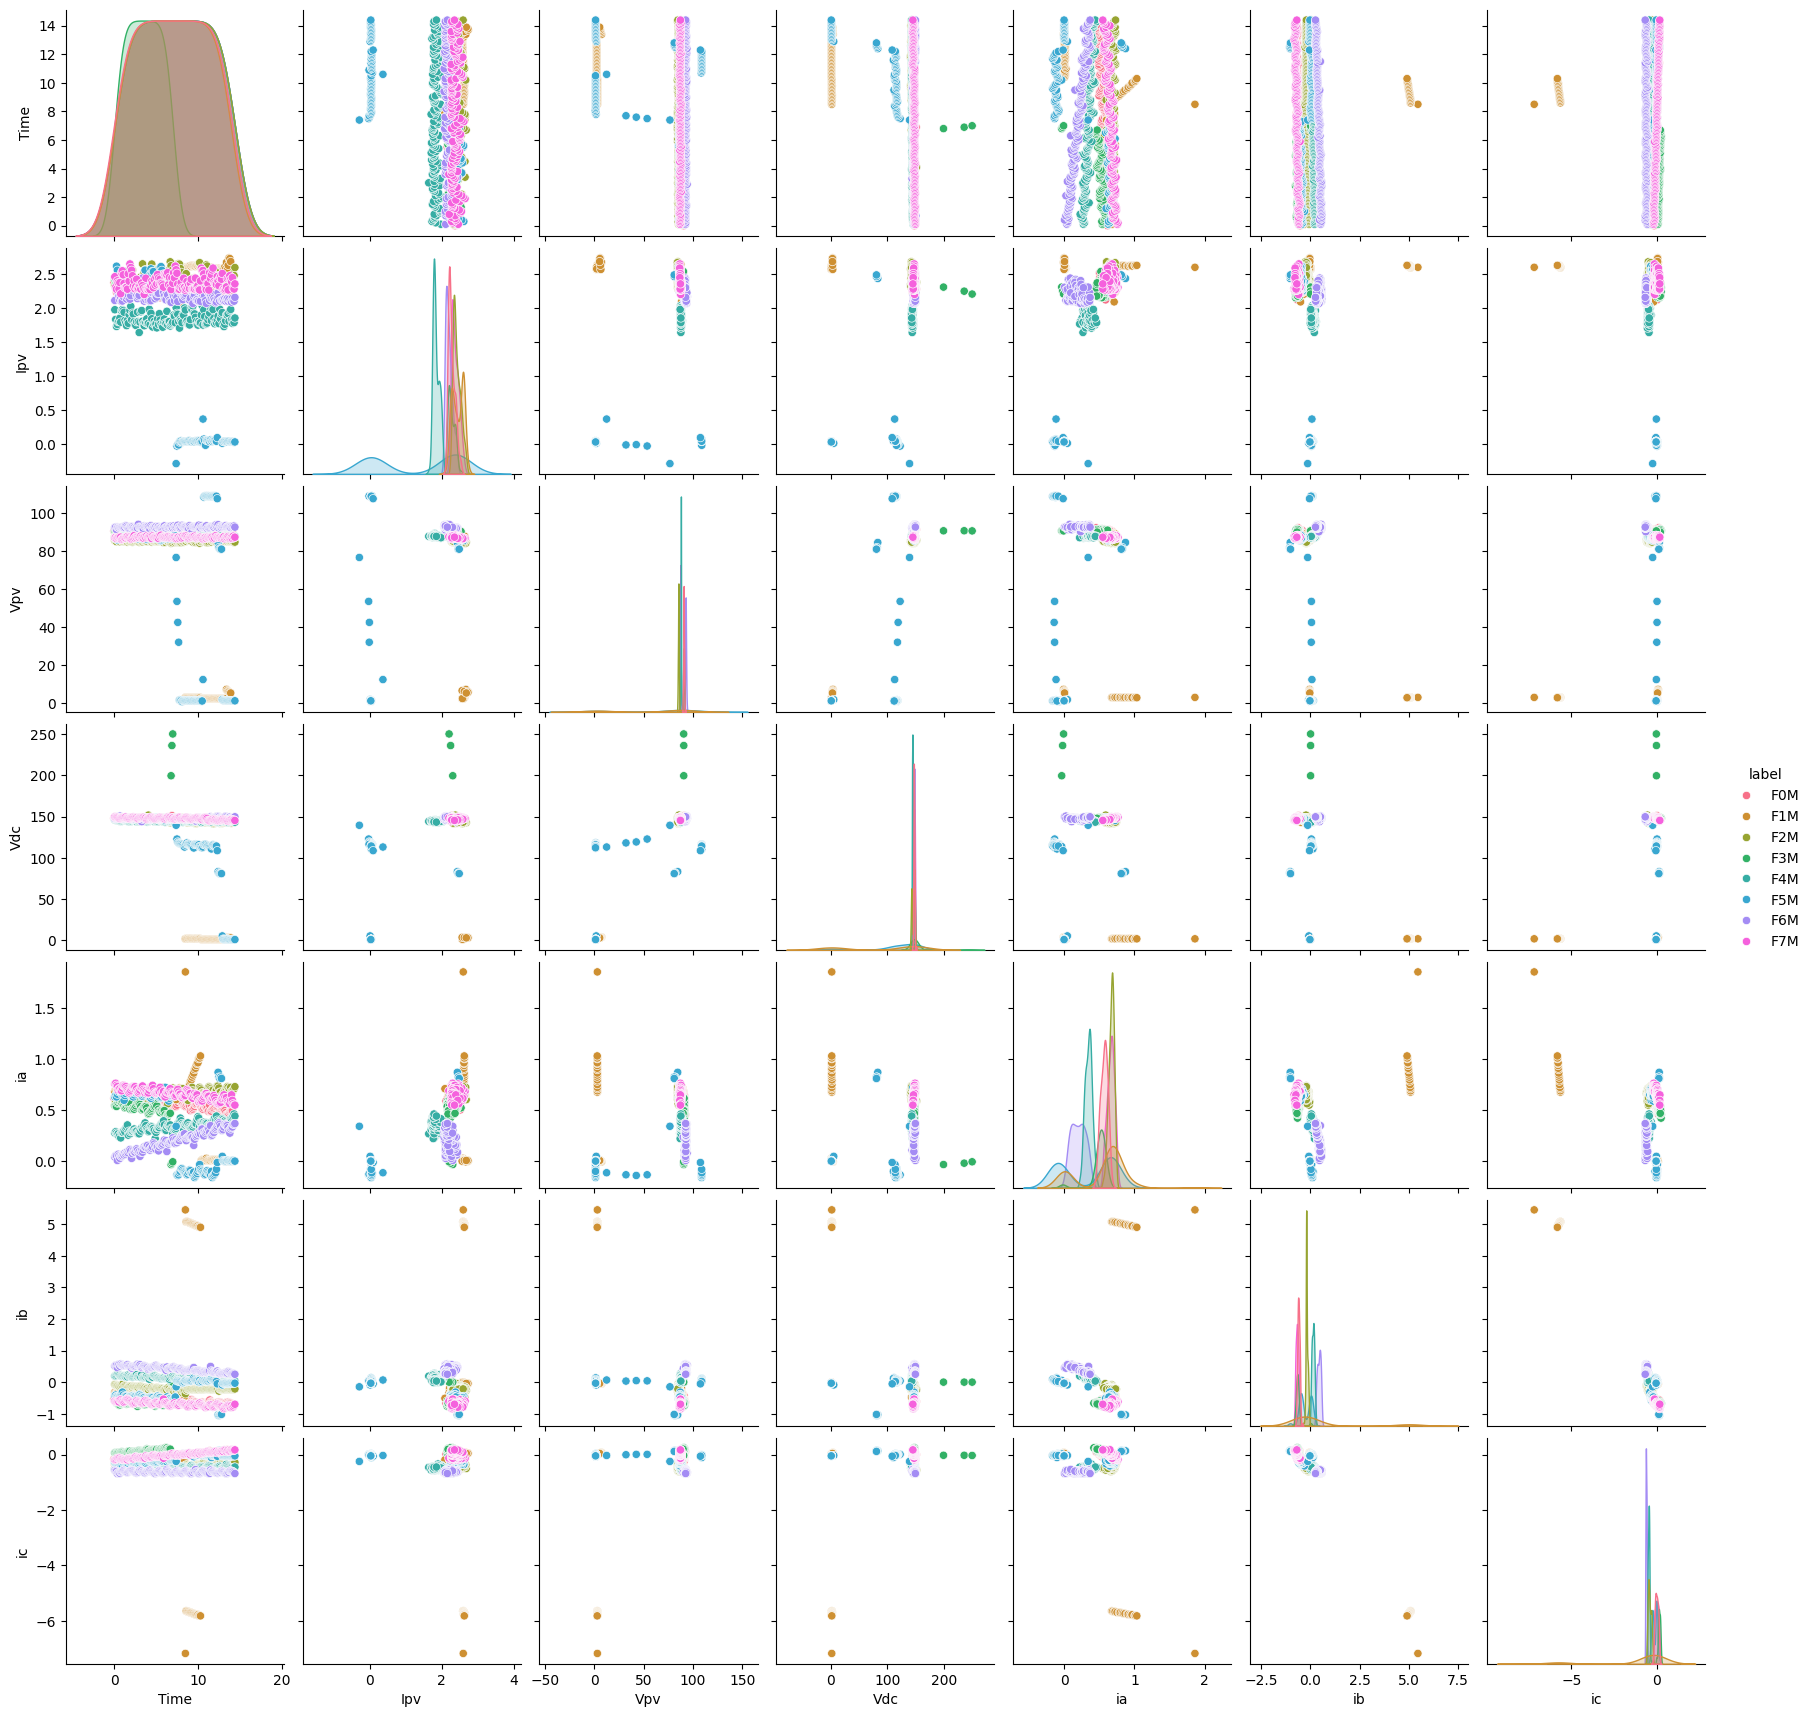

In [31]:
solar_Max_power1= solar_Max_power.iloc[::1000,:]
sns.pairplot(solar_Max_power1[['Time','Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'label']], hue='label', palette='husl')
plt.show()

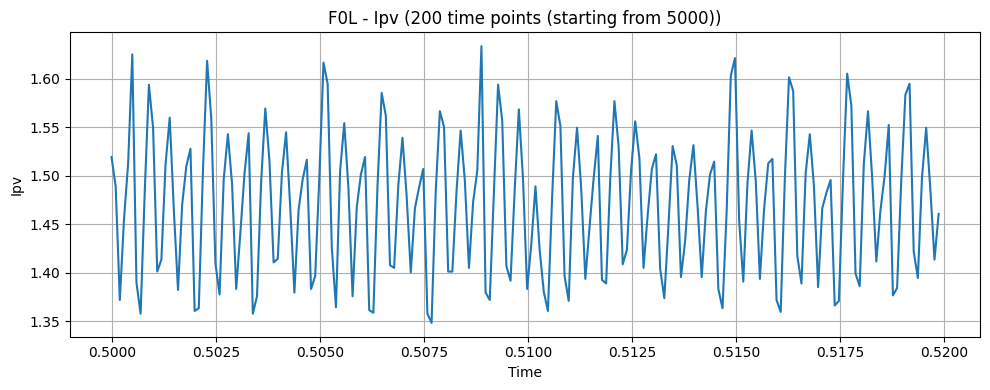

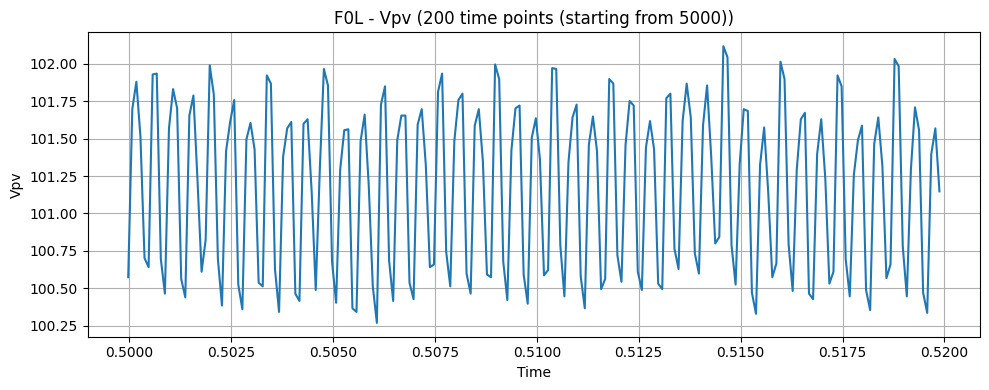

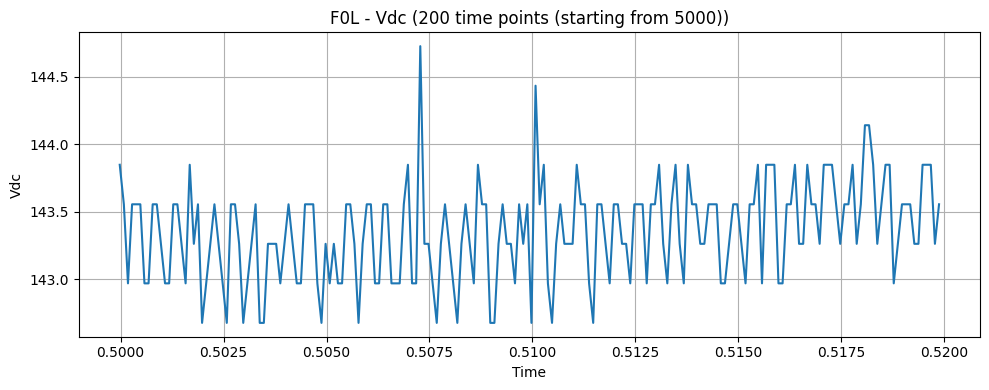

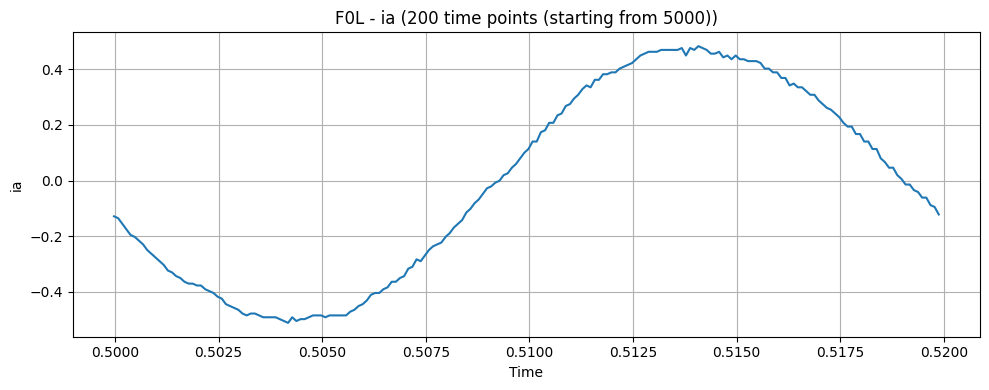

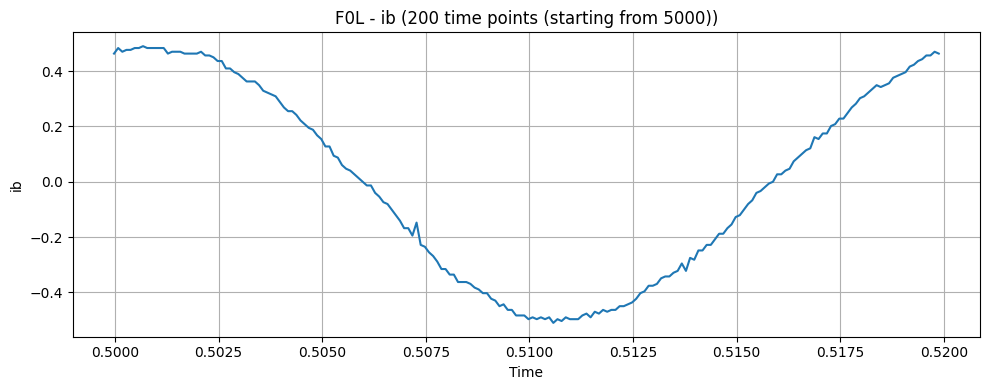

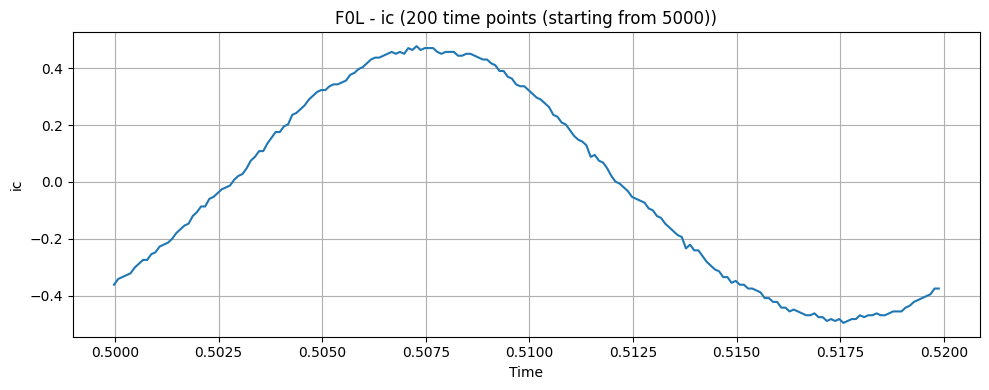

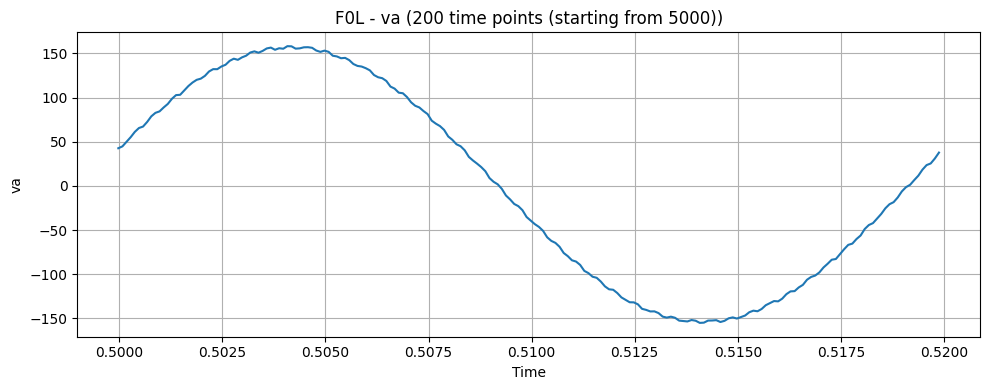

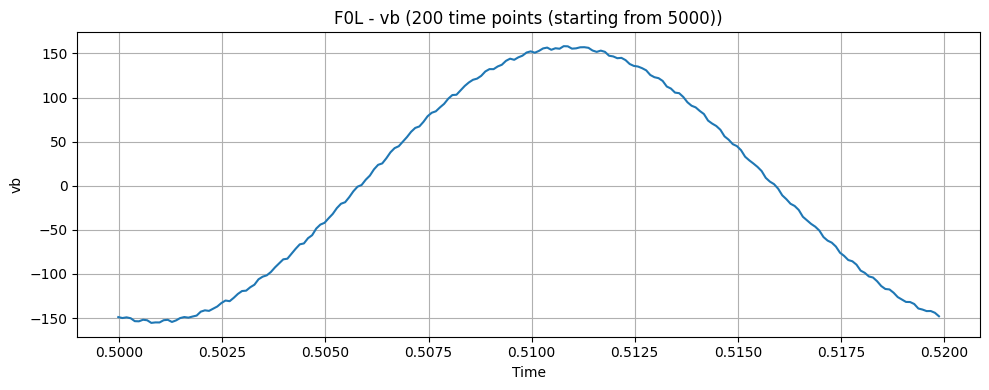

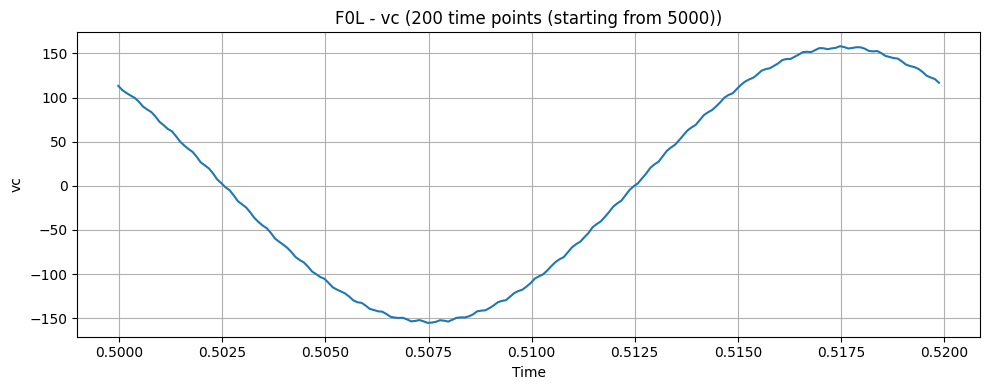

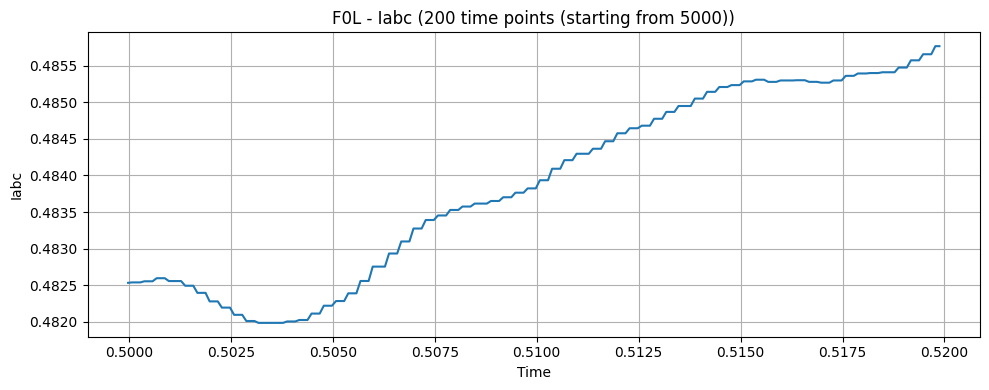

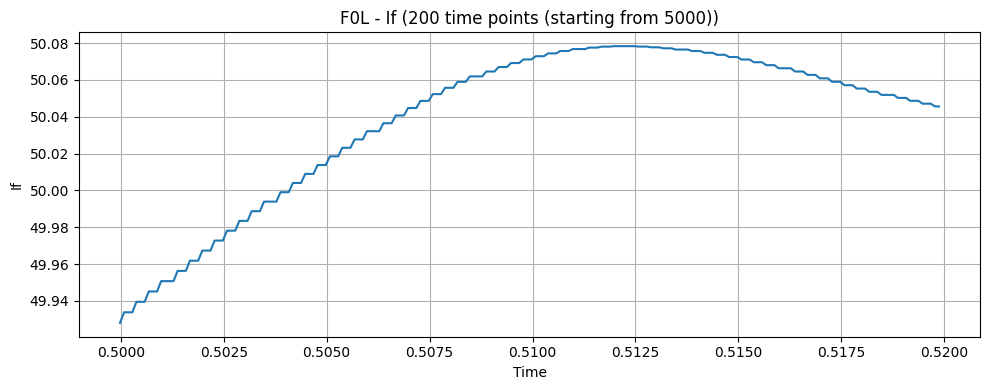

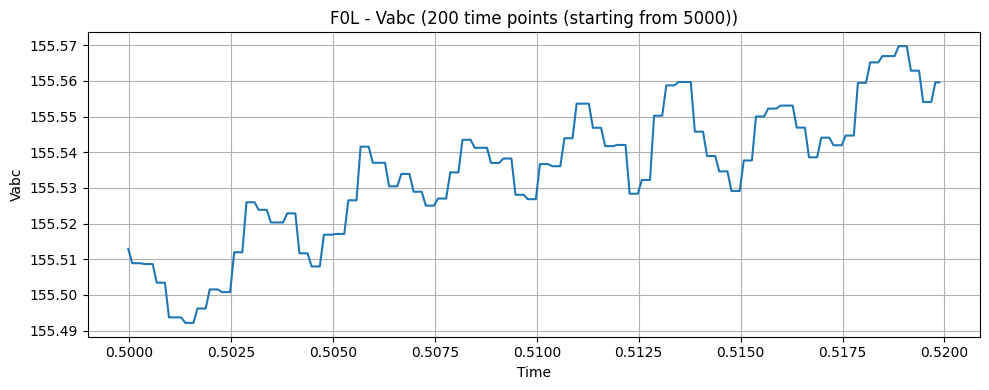

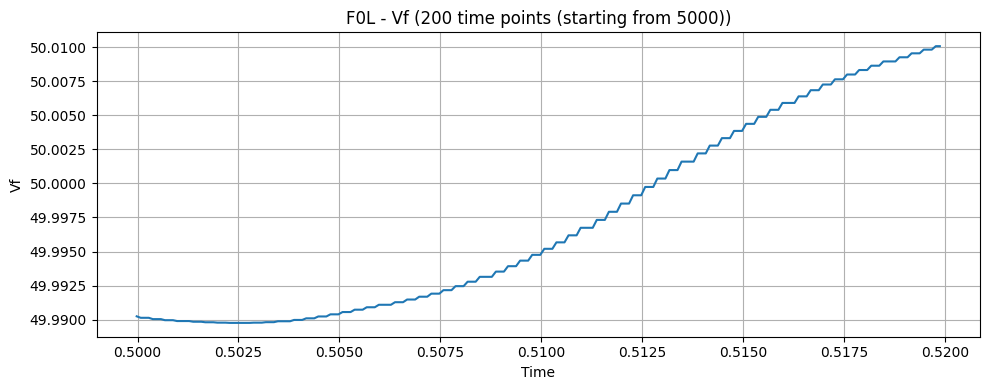

In [47]:
def plot_each_variable(df, variables, first_point=0, n_points=256):
    
    for var in variables:
        plt.figure(figsize=(10, 4))
        plt.plot(df['Time'][first_point:n_points + first_point], df[var][first_point :n_points + first_point], color='tab:blue')
        plt.title(f"{df['label'].iloc[0]} - {var} ({n_points} time points (starting from {first_point}))")
        plt.xlabel("Time")
        plt.ylabel(var)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_each_variable(
    F0L,
    ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf'],
    first_point=5000,
    n_points=200  # You can change to 512, 1024, etc.
)